# Currency exchange rate trends analyzer

### Trend analysis for EURPLN exchange rates using data from 2013.09.09 to 2016.09.05 time period

In [95]:
# customarilily import most important libraries

import pandas as pd                       # pandas is a dataframe library
import matplotlib.pyplot as plt           # matplotlib.pyplot plots data
import numpy as np                        # numpy provides N-dim object support

import matplotlib.dates as mdates 
import math


# do ploting inline instead of in a separate window
%matplotlib inline

In [96]:
df = pd.read_csv('./data-archive/EUR_2013.09.09_2016.09.05.csv', sep=';')     # load data

In [97]:
# get brief statistics over data we just read
df_columns, df_rows = df.shape

print("File contains {} rows and {} columns of data.".format(df_columns, df_rows))

File contains 755 rows and 4 columns of data.


#### Show first 3 rows from file

In [98]:
df.head(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
0,2016-09-05,4.3480,-0.72,171/A/NBP/2016
1,2016-09-02,4.3796,0.43,170/A/NBP/2016
2,2016-09-01,4.3607,0.12,169/A/NBP/2016


#### Show last 3 rows from file

In [99]:
df.tail(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
752,2013-09-11,4.2408,-0.54,176/A/NBP/2013
753,2013-09-10,4.2637,-0.15,175/A/NBP/2013
754,2013-09-09,4.2700,-0.64,174/A/NBP/2013


As we can see, data are not ordered chronologically. We must reverse the order of rows so that first row is the oldest, last row is the newest.

In [100]:
df = df.sort_index(axis=0, ascending=True)
df = df.iloc[::-1]
df.head(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
754,2013-09-09,4.2700,-0.64,174/A/NBP/2013
753,2013-09-10,4.2637,-0.15,175/A/NBP/2013
752,2013-09-11,4.2408,-0.54,176/A/NBP/2013


In [101]:
df.tail(3)

,Data,Kurs,Zmiana,Nazwa Tabeli
2,2016-09-01,4.3607,0.12,169/A/NBP/2016
1,2016-09-02,4.3796,0.43,170/A/NBP/2016
0,2016-09-05,4.3480,-0.72,171/A/NBP/2016


Data frame (rows) is reversed now, which we can prove by observing values on the diagram

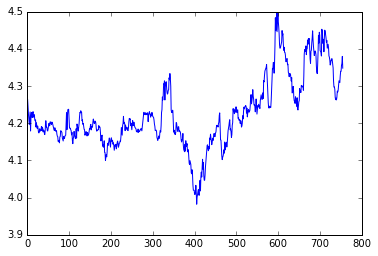

In [102]:
plt.plot(df['Kurs'].values)

### SMA - simple moving average

In [103]:
# an example on how to calculate SMA for a collection of data
v = {'score': [1, 2, 2, 3, 3, 4]}
data_frame = pd.DataFrame(v)
pd.rolling_mean(data_frame, 2)

,score
0,NaN
1,1.5
2,2.0
3,2.5
4,3.0
5,3.5


#### Calculate various SMA 

In order to perform better analysis, we will use recent data

In [104]:
# get last 100 exchange rates
last_days_to_analyze = 300
last_days_to_observe = 200

recent_exchange_rates = df['Kurs'].values[-last_days_to_analyze:]
recent_dates = df['Data'].values[-last_days_to_analyze:]

In [105]:
# create new DataFrame containing exchange rates ordered chronologically (oldest first, newest last)
df_exchange_rates = pd.DataFrame(recent_exchange_rates)

# define SMA windows (for short-term trading)
sma_windows = [3, 5, 7, 10, 20, 50]

# calculate SMA-3, SMA-5 and so on..
df_sma = {}
for window in sma_windows:
    df_sma[window] = pd.rolling_mean(df_exchange_rates, window)

In [106]:
# get data for last days we are interested in
recent_exchange_rates = recent_exchange_rates[-last_days_to_observe:]
recent_dates = recent_dates[-last_days_to_observe:]

#### Plot exchange rates along with different SMA

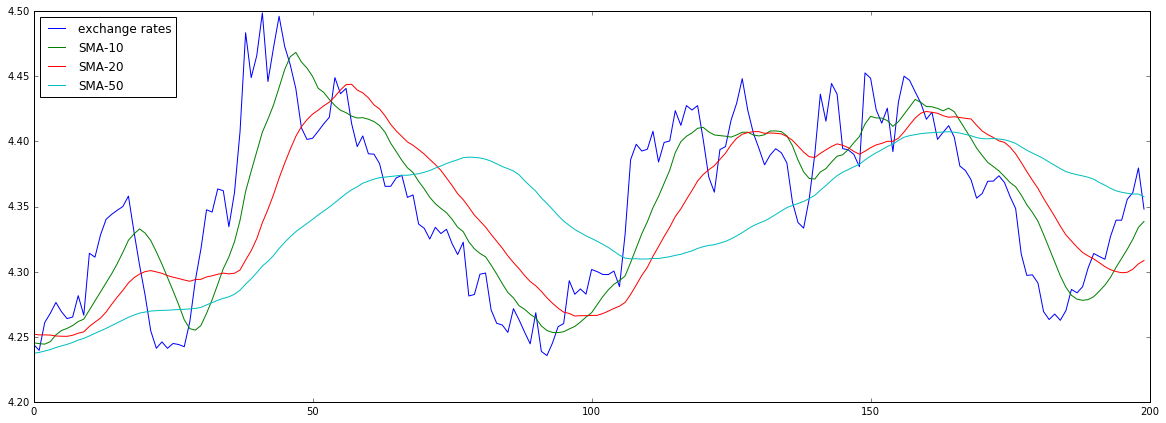

In [107]:
plt.figure(figsize=(20,7))

plt.plot(recent_exchange_rates)
# sma-10
plt.plot(df_sma[10][-last_days_to_observe:].values)
# sma-20
plt.plot(df_sma[20][-last_days_to_observe:].values)
# sma-50
plt.plot(df_sma[50][-last_days_to_observe:].values)

plt.legend(['exchange rates', 'SMA-10', 'SMA-20', 'SMA-50'], loc='upper left')

### Example on how to find points where the curves intersect

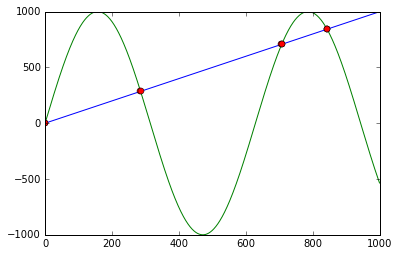

In [108]:

x = np.arange(0, 1000)
f = np.arange(0, 1000)
g = np.sin(np.arange(0, 10, 0.01)) * 1000

plt.plot(x, f, '-')
plt.plot(x, g, '-')

idx = np.argwhere(np.isclose(f, g, atol=10)).reshape(-1)
plt.plot(x[idx], f[idx], 'ro')
plt.show()

Comment: This way of finding intersection point did not prove to be good in our special case

#### Let's analyze which SMA is the best in terms of mirroring trend 

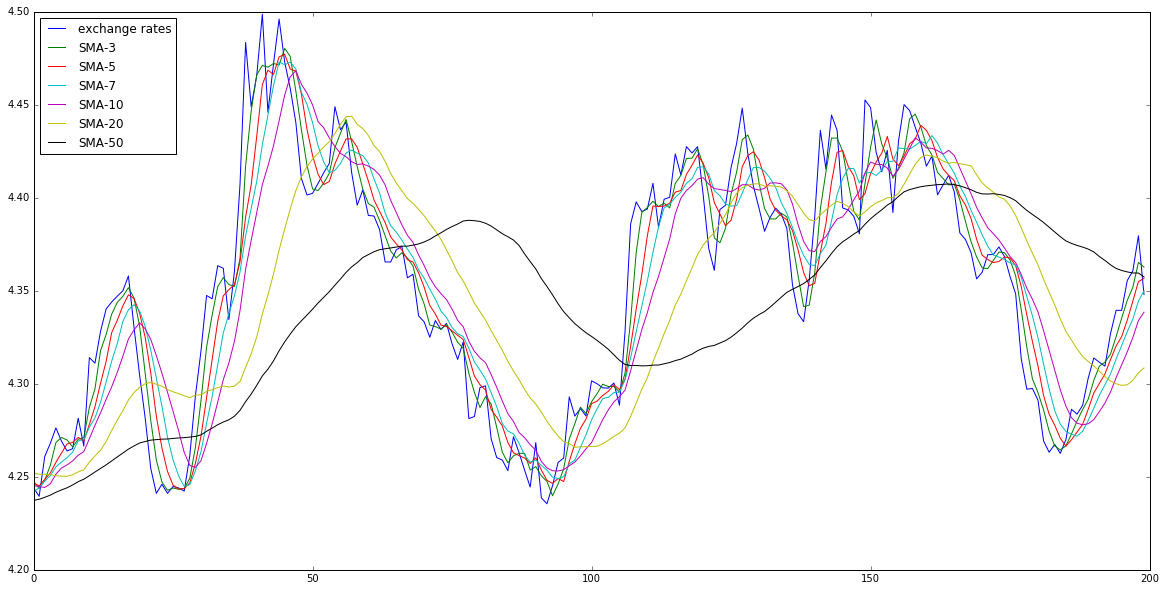

In [109]:
plt.figure(figsize=(20,10))

# plot unchanged history of exchange rates
plt.plot(recent_exchange_rates)

legend = []
legend.append('exchange rates')
for window in sma_windows:
    plt.plot(df_sma[window][-last_days_to_observe:].values)
    legend.append('SMA-{}'.format(window))
    
# plot dynamically created legend
plt.legend(legend, loc='upper left')

Conclusion: The SMA-3, SMA-5, SMA-7, and SMA-10 are the best dataset in terms of mirroring exchange rates

#### Calculate intersection points between various SMA data ranges

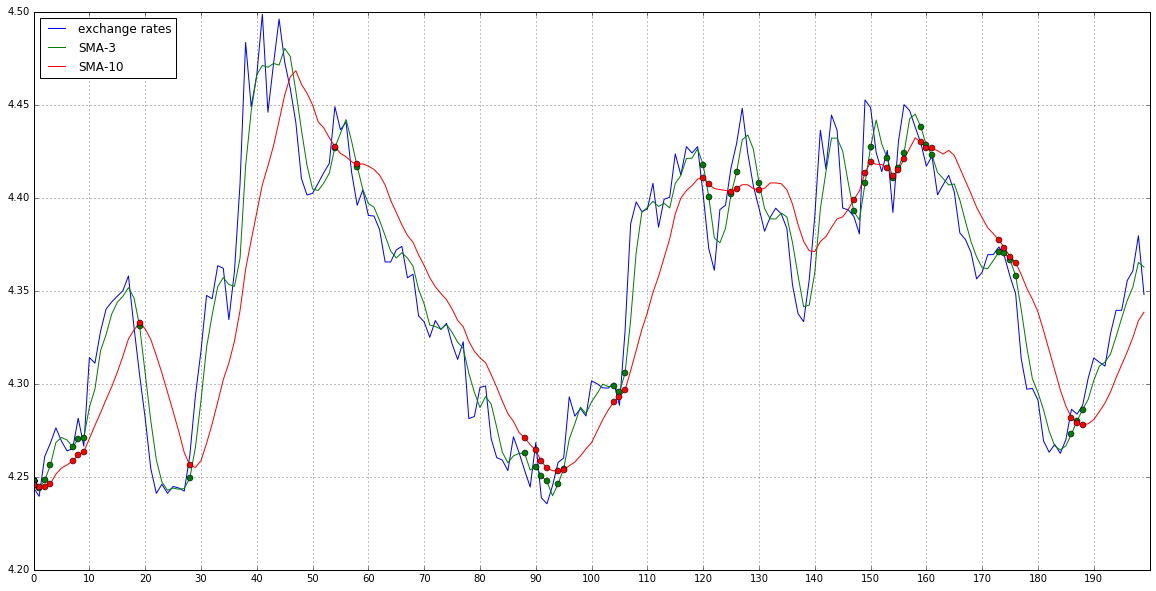

In [110]:
def plot_pair(pair):
    window1 = pair[0]
    window2 = pair[1]
    # get SMA values for interesting windows
    sma1 = df_sma[window1][-last_days_to_observe:].values
    sma2 = df_sma[window2][-last_days_to_observe:].values
    # calculate crossing points between both value ranges
    intersection_points = np.argwhere(np.isclose(sma1, sma2, atol=0.01)).reshape(-1)
    # plot
    plt.plot(sma1)
    plt.plot(sma2)
    plt.plot(intersection_points, sma1[intersection_points], 'go')
    plt.plot(intersection_points, sma2[intersection_points], 'ro')
    plt.xticks(np.arange(0, last_days_to_observe, 10))
    # return
    return list(intersection_points)[::2]


# set up plotting parameters
plt.figure(figsize=(20,10))
plt.grid(True)

plt.plot(recent_exchange_rates)    
comparison_pair = (3, 10)
intersection_points = plot_pair(comparison_pair)
plt.legend(['exchange rates', "SMA-{}".format(comparison_pair[0]), "SMA-{}".format(comparison_pair[1])], loc='upper left')


### What's wrong with intersection between 40-50??

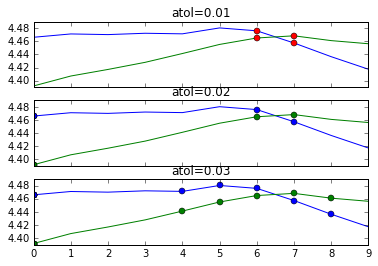

In [111]:
x1 = 40
x2 = 50

test_sma_1 = df_sma[3][-200+x1:-200+x2].values
test_sma_2 = df_sma[10][-200+x1:-200+x2].values

intpoints_v1 = np.argwhere(np.isclose(test_sma_1, test_sma_2, atol=0.01)).reshape(-1)
intpoints_v2 = np.argwhere(np.isclose(test_sma_1, test_sma_2, atol=0.02)).reshape(-1)
intpoints_v3 = np.argwhere(np.isclose(test_sma_1, test_sma_2, atol=0.03)).reshape(-1)

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.set_title("atol=0.01")
ax1.plot(test_sma_1)
ax1.plot(test_sma_2)
ax1.plot(intpoints_v1, test_sma_1[intpoints_v1], 'bo')
ax1.plot(intpoints_v1, test_sma_2[intpoints_v1], 'go')
ax1.plot(6, test_sma_1[6], 'ro')
ax1.plot(7, test_sma_1[7], 'ro')
ax1.plot(6, test_sma_2[6], 'ro')
ax1.plot(7, test_sma_2[7], 'ro')

ax2.set_title("atol=0.02")
ax2.plot(test_sma_1)
ax2.plot(test_sma_2)
ax2.plot(intpoints_v2, test_sma_1[intpoints_v2], 'bo')
ax2.plot(intpoints_v2, test_sma_2[intpoints_v2], 'go')

ax3.set_title("atol=0.03")
ax3.plot(test_sma_1)
ax3.plot(test_sma_2)
ax3.plot(intpoints_v3, test_sma_1[intpoints_v3], 'bo')
ax3.plot(intpoints_v3, test_sma_2[intpoints_v3], 'go')


In [112]:
print("Intersection points between SMA-{} and SMA-{}".format(comparison_pair[0], comparison_pair[1]))
print(intersection_points)
#print()
#print("Exchange rates on such days:")
#for i in intersection_points:
#    print("{} ==> date: {}, exchange rate: {}".format(i, recent_dates[i], recent_exchange_rates[i]))
#print()

Intersection points between SMA-3 and SMA-10
[0, 1, 2, 3, 7, 8, 9, 19, 28, 54, 58, 88, 90, 91, 92, 94, 95, 104, 105, 106, 120, 121, 125, 126, 130, 147, 149, 150, 153, 154, 155, 156, 159, 160, 161, 173, 174, 175, 176, 186, 187, 188]


In [113]:
#
# line segment intersection using vectors
# see Computer Graphics by F.S. Hill
#
# Stolen directly from http://www.cs.mun.ca/~rod/2500/notes/numpy-arrays/numpy-arrays.html
#
from numpy import *
def perp(a):
    b = empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b


# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1, a2, b1, b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = dot( dap, db)
    num = dot( dap, dp )
    return (num / denom.astype(float))*db + b1


def get_intersection_point_between_points(a1, a2, b1, b2):
    intersection_point = seg_intersect(a1, a2, b1, b2)    
    intersection_point_x = intersection_point[0]
    
    if intersection_point_x >= max([a1[0], b1[0]]) and intersection_point_x <= min([a2[0], b2[0]]):
        return intersection_point
    else:
        return [nan, nan] 

    
def get_intersection_points(x_values, y_values_1, y_values_2):
    intersection_points = []
    for x in x_values[:-1]:
        point = get_intersection_point_between_points(array([x, y_values_1[x]]), \
                                                      array([x+1, y_values_1[x+1]]), \
                                                      array([x, y_values_2[x]]), \
                                                      array([x+1, y_values_2[x+1]]))       
        if not math.isnan(point[0]):
            intersection_points.append(point)    
    return intersection_points
                        
            
# some test cases
#p1_1 = array([ 0, 4.46613333])
#p1_2 = array([ 1, 4.4712])
#p2_1 = array([ 0, 4.39197])
#p2_2 = array([ 1, 4.40709])
#print(seg_intersect(p1_1, p1_2, p2_1, p2_2))
#print(get_intersection_point_in_range(p1_1, p1_2, p2_1, p2_2))


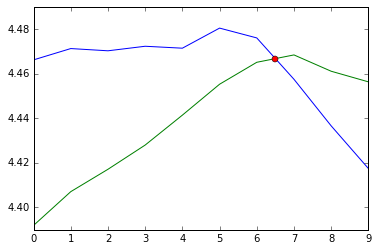

In [114]:
x1 = 40
x2 = 50

x_values = list(range(0, x2-x1, 1))
test_sma_1 = df_sma[3][-200+x1:-200+x2].values
test_sma_2 = df_sma[10][-200+x1:-200+x2].values

test_sma_1_flattened = [item for sublist in test_sma_1 for item in sublist]
test_sma_2_flattened = [item for sublist in test_sma_2 for item in sublist]

intpoints_v1 = get_intersection_points(x_values, test_sma_1_flattened, test_sma_2_flattened)

f, ax1 = plt.subplots(1, sharex=True, sharey=True)
ax1.plot(test_sma_1)
ax1.plot(test_sma_2)

for intpoint in intpoints_v1:
    ax1.plot(intpoint[0], intpoint[1], 'ro')



### Now we have better algorithm of finding intersection points, so it's time redraw 

IndexError: list index out of range

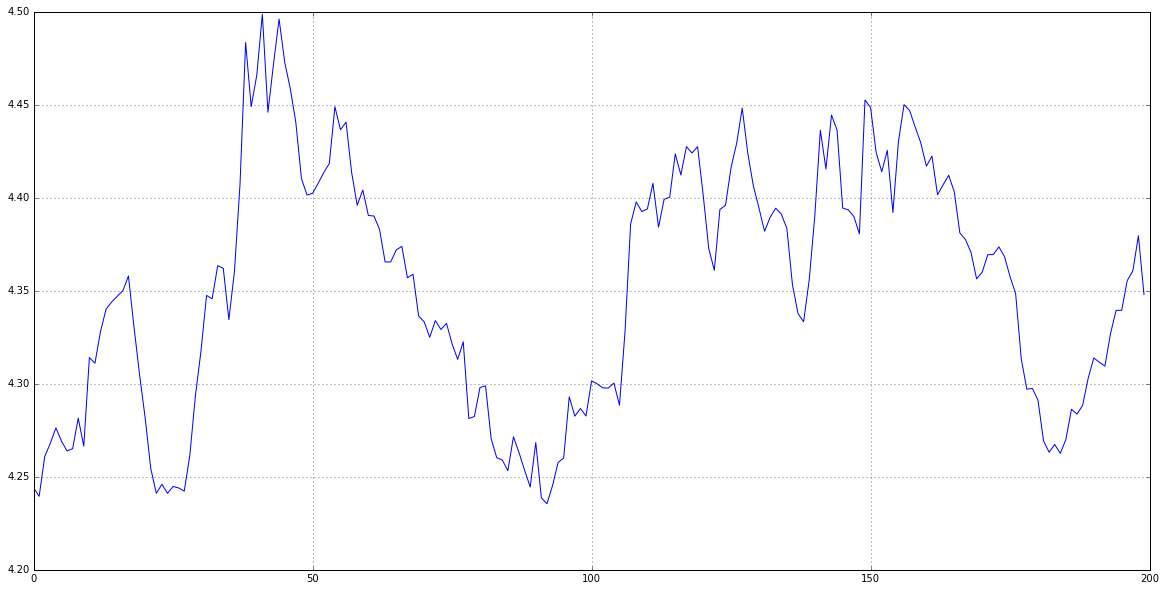

In [115]:
def plot_pair_v2(pair):
    window1 = pair[0]
    window2 = pair[1]
    # get SMA values for interesting windows
    sma1 = df_sma[window1][-last_days_to_observe:].values
    sma2 = df_sma[window2][-last_days_to_observe:].values
    
    # make extra calculations that simplify process of finding crossing points
    x_values = range(0, len(sma1), 1)
    sma_1_flattened = [item for sublist in test_sma_1 for item in sublist]
    sma_2_flattened = [item for sublist in test_sma_2 for item in sublist]

    # calculate crossing points between both value ranges
    intersection_points = get_intersection_points(x_values, sma_1_flattened, sma_2_flattened)
    # plot
    plt.xticks(np.arange(0, last_days_to_observe, 10))

    plt.plot(sma1)
    plt.plot(sma2)
    for intpoint in intpoints_v1:
        plt.plot(intpoint[0], intpoint[1], 'ro')

    # return all interesction points
    return list(intersection_points)[::2]


# set up plotting parameters
plt.figure(figsize=(20,10))
plt.grid(True)

plt.plot(recent_exchange_rates)    
comparison_pair = (3, 10)
intersection_points = plot_pair_v2(comparison_pair)
plt.legend(['exchange rates', "SMA-{}".format(comparison_pair[0]), "SMA-{}".format(comparison_pair[1])], loc='upper left')
